
# Experiments with PDFA Learning

The goal of the notebook is to experiment with manipulating and learning pdfa.

## Generating traces from a learning target

We will be defining a model to learn, and then sampling from it such that we can learn from the generated corpus.

### Target Definition

Here, we define a three-state PDFA in a YAML configuration file:

In [1]:
%load_ext autoreload
%autoreload 2

from pygments import highlight
from pygments.lexers import YamlLexer
from pygments.formatters import HtmlFormatter
import IPython
config_file = 'wombats/config/pdfa_self_driving_config.yaml'

with open(config_file) as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, YamlLexer(), formatter)))

### Loading into Wombats®

Now that we have defined an automaton, we can load it into wombats®:

In [2]:
from wombats.automaton import active_automata
from sklearn.model_selection import train_test_split
import numpy as np

pdfa_model = active_automata.get(automaton_type='PDFA',
                                 graph_data=config_file)

Now that we have built the model, let's see what it looks like:

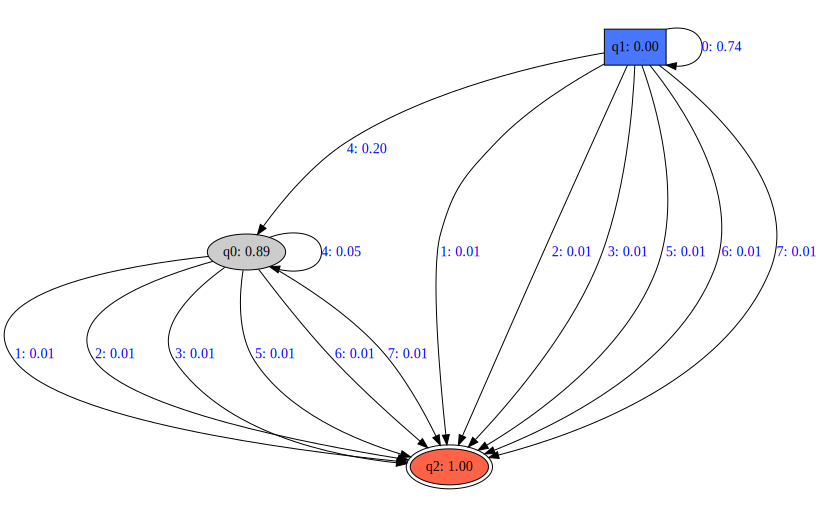

In [3]:
pdfa_model.draw_IPython()

### Sampling from the target PDFA

With the model built, we can sample a trace from it:

In [5]:
(trace, trace_len,
 trace_prob) = pdfa_model.generate_trace(pdfa_model.start_state, N=20)
print("Trace:", trace)
print("Probability of trace in language of the model:", trace_prob[0])

Trace: [0, 4]
Probability of trace in language of the model: 0.148


### Creating a test / training split

Here, we can generate all of the data for our learning algorithms to use:

In [ ]:
num_samples = 1_000_000
max_trace_length = 30
(traces,
 trace_lengths,
 trace_probs) = pdfa_model.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
num_traces_train = len(traces_train)
num_traces_test = len(traces_test)
pdfa_model.write_traces_to_file(traces_train, num_traces_train,
                                traceLengths_train,
                                f_name='PDFASamples_train.swag')
pdfa_model.write_traces_to_file(traces_test, num_traces_test,
                                traceLengths_test,
                                f_name='PDFASamples_test.swag')

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 356 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 12448 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 34848 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 63648 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 98848 tasks      | elapsed:   23.6s
[Parallel(n_jobs=16)]: Done 140448 tasks      | elapsed:   33.0s
[Parallel(n_jobs=16)]: Done 188448 tasks      | elapsed:   44.3s
[Parallel(n_jobs=16)]: Done 242848 tasks      | elapsed:   57.9s
[Parallel(n_jobs=16)]: Done 303648 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 370848 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 444448 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 524448 tasks      | elapsed:  2.1min
[Parallel(n_jobs=16)]: Done 610848 tasks      | elapsed:  2.6min


Now that we have built the model, let's see what it looks like:

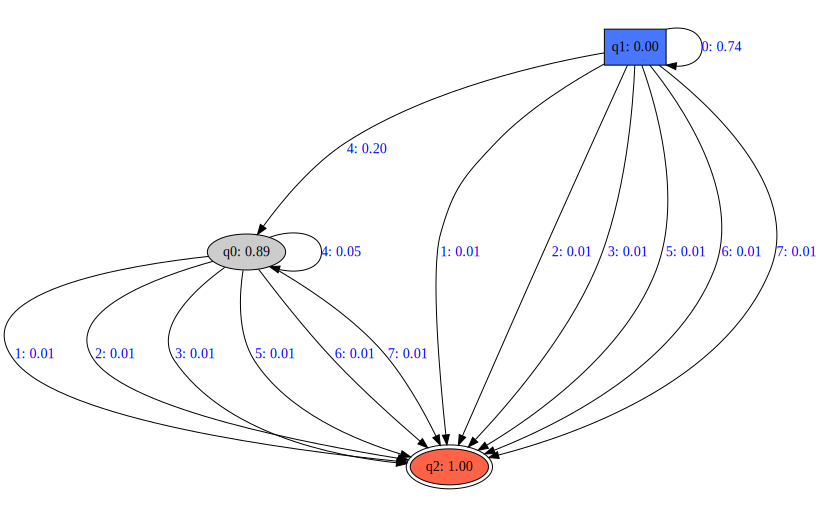

In [62]:
pdfa_model.draw_IPython()

## Learning a PDFA with Flexfringe

Two choices: Using it via Python function calls, or working with the command line.

### Step 1

Install all dependencies and compile flexfringe (development branch due to some technicalities using WIFEXITED macro used for the SAT solver's process)

In [ ]:
# for the C++ code
!apt install graphviz
!apt install libgsl-dev
!apt install libpopt-dev

# for visualization and notebook interface
!pip install graphviz

# Stamina data
!wget http://stamina.chefbe.net/downloads/grid.tar.gz
!tar xfz grid.tar.gz

# cloning the repository
!rm -rf dfasat
!git clone https://bitbucket.org/chrshmmmr/dfasat.git

In [ ]:
# building the repository
# it is important to check out the development branch on colab
!cd dfasat && git checkout  && make clean all

### Step 2 
Import flexfringe tool interface

In [63]:
%autoreload 2
from wombats.learning import FlexfringeInterface

flexfringe = FlexfringeInterface()

### Step 3

Run grammatical inference using the flexfringe tool with the filename and named arguments just as described in help.

In [64]:
flexfringe.infer_model(training_file='')

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=alergia -d=alergia_data --output-dir=./dfa PDFASamples_train.swag 
sat_program : 
valid: alergia
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic alergia
Creating apta using evaluation class alergia_data
batch mode selected
reading data finished, processing:
dfasat running x1338  x1018  x748  x568  x424  x316  m58  m8  m7  m7  m6  x115  m5  m4  m1  m1  m1  m1  m1  m1  x10  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  

found intermediate solution with 9 and 9 red states
No valid solver specified, skipping...



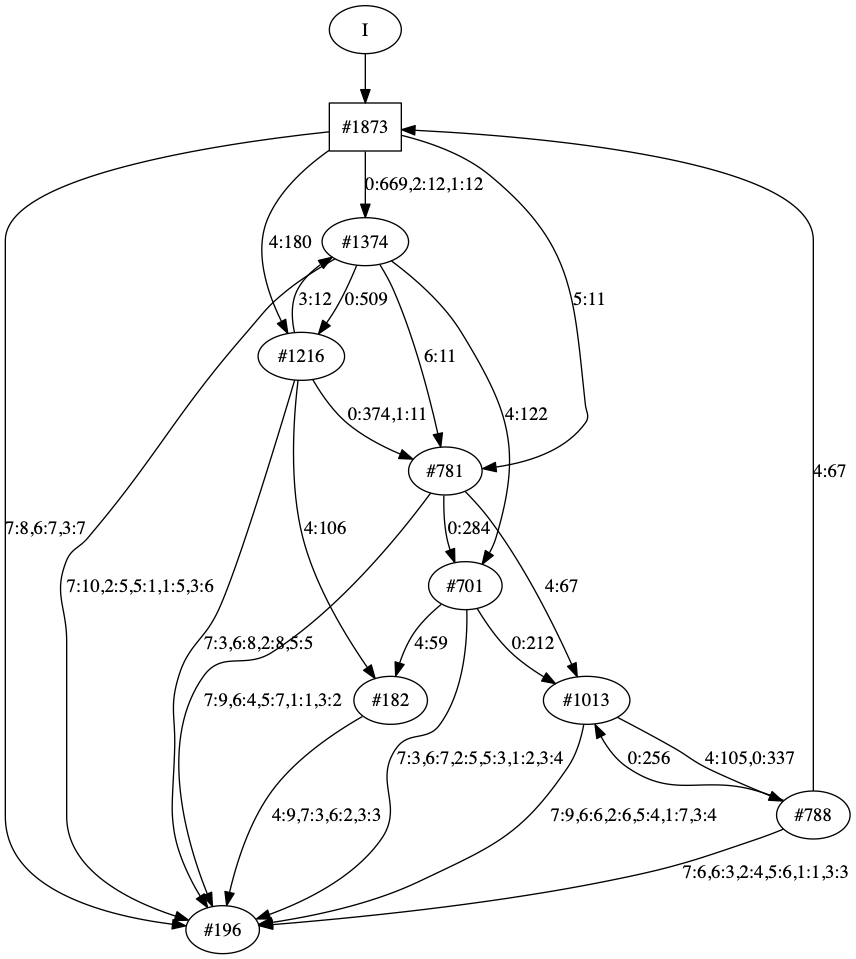

In [65]:
data = flexfringe.infer_model(training_file='PDFASamples_train.swag',
                              h='alergia',
                              d='alergia_data')
flexfringe.draw_IPython(data)

## Loading Learned Flexfringe Model into Wombats

We first must get the output from flexfringe and convert it into a proper FDFA:

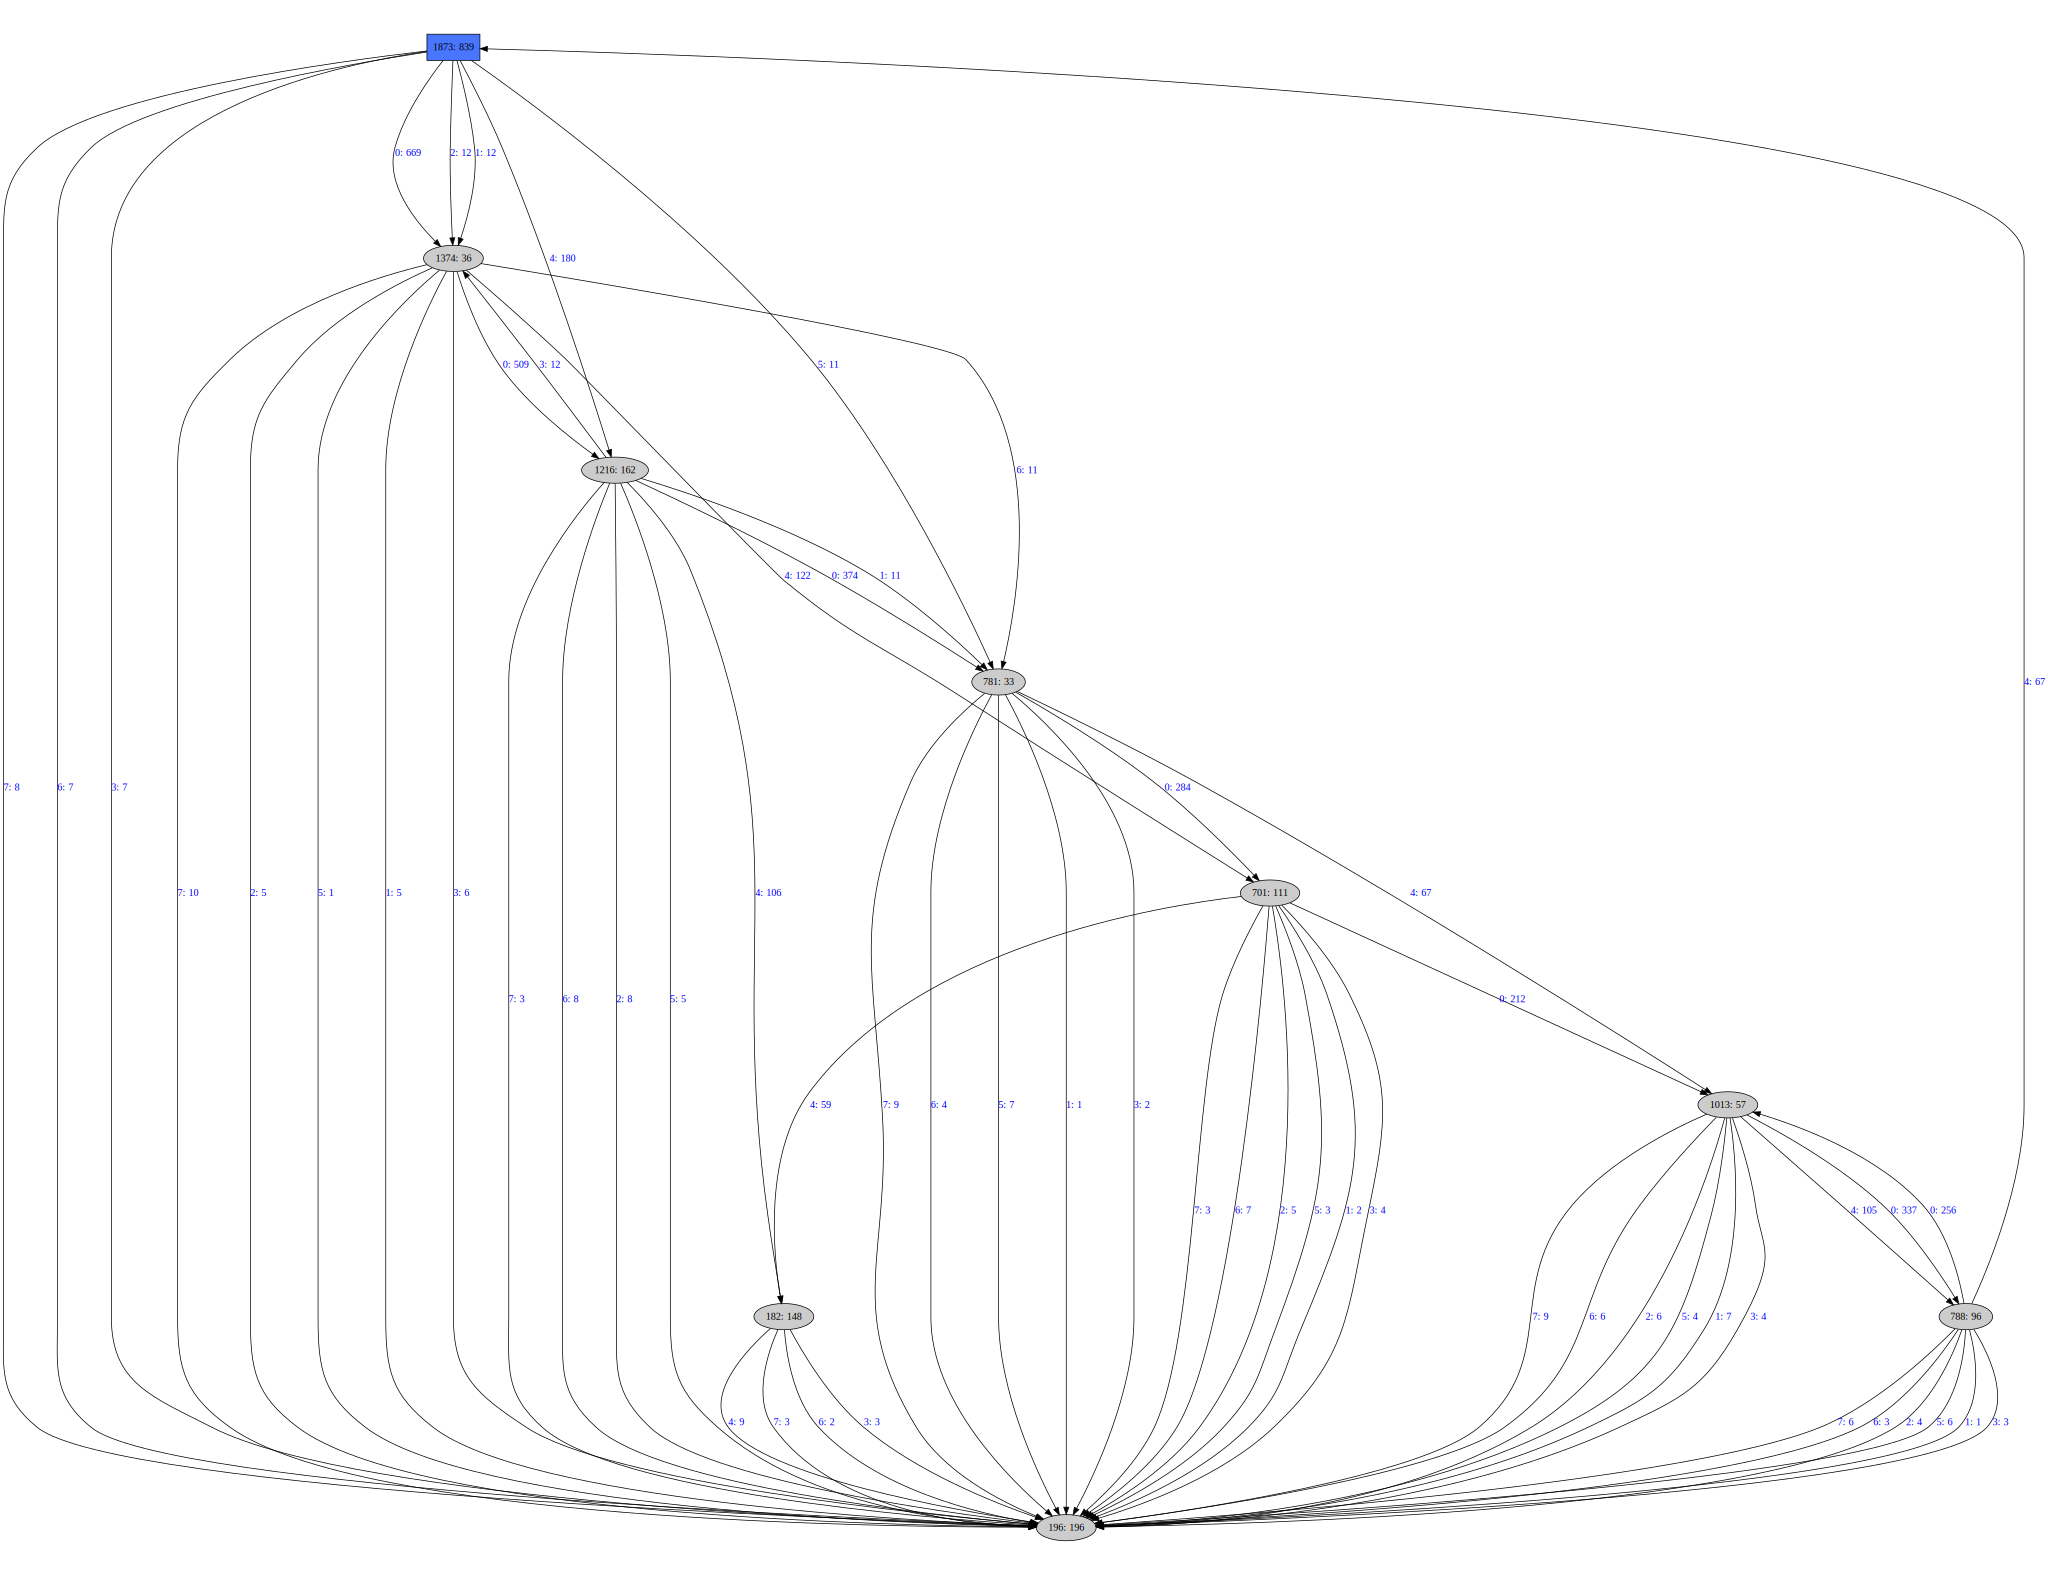

In [66]:
%autoreload 2

# learned_fdfa = active_automata.get(automaton_type='FDFA',
#                                    graph_data=data,
#                                    graph_data_format='dot_string')
# or
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe.learned_model_filepath,
                                   graph_data_format='dot_file')
learned_fdfa.draw_IPython()

With the FDFA loaded in, we use wombat conversion utilities to convert the FDFA to a PDFA (the same format as our learning target):

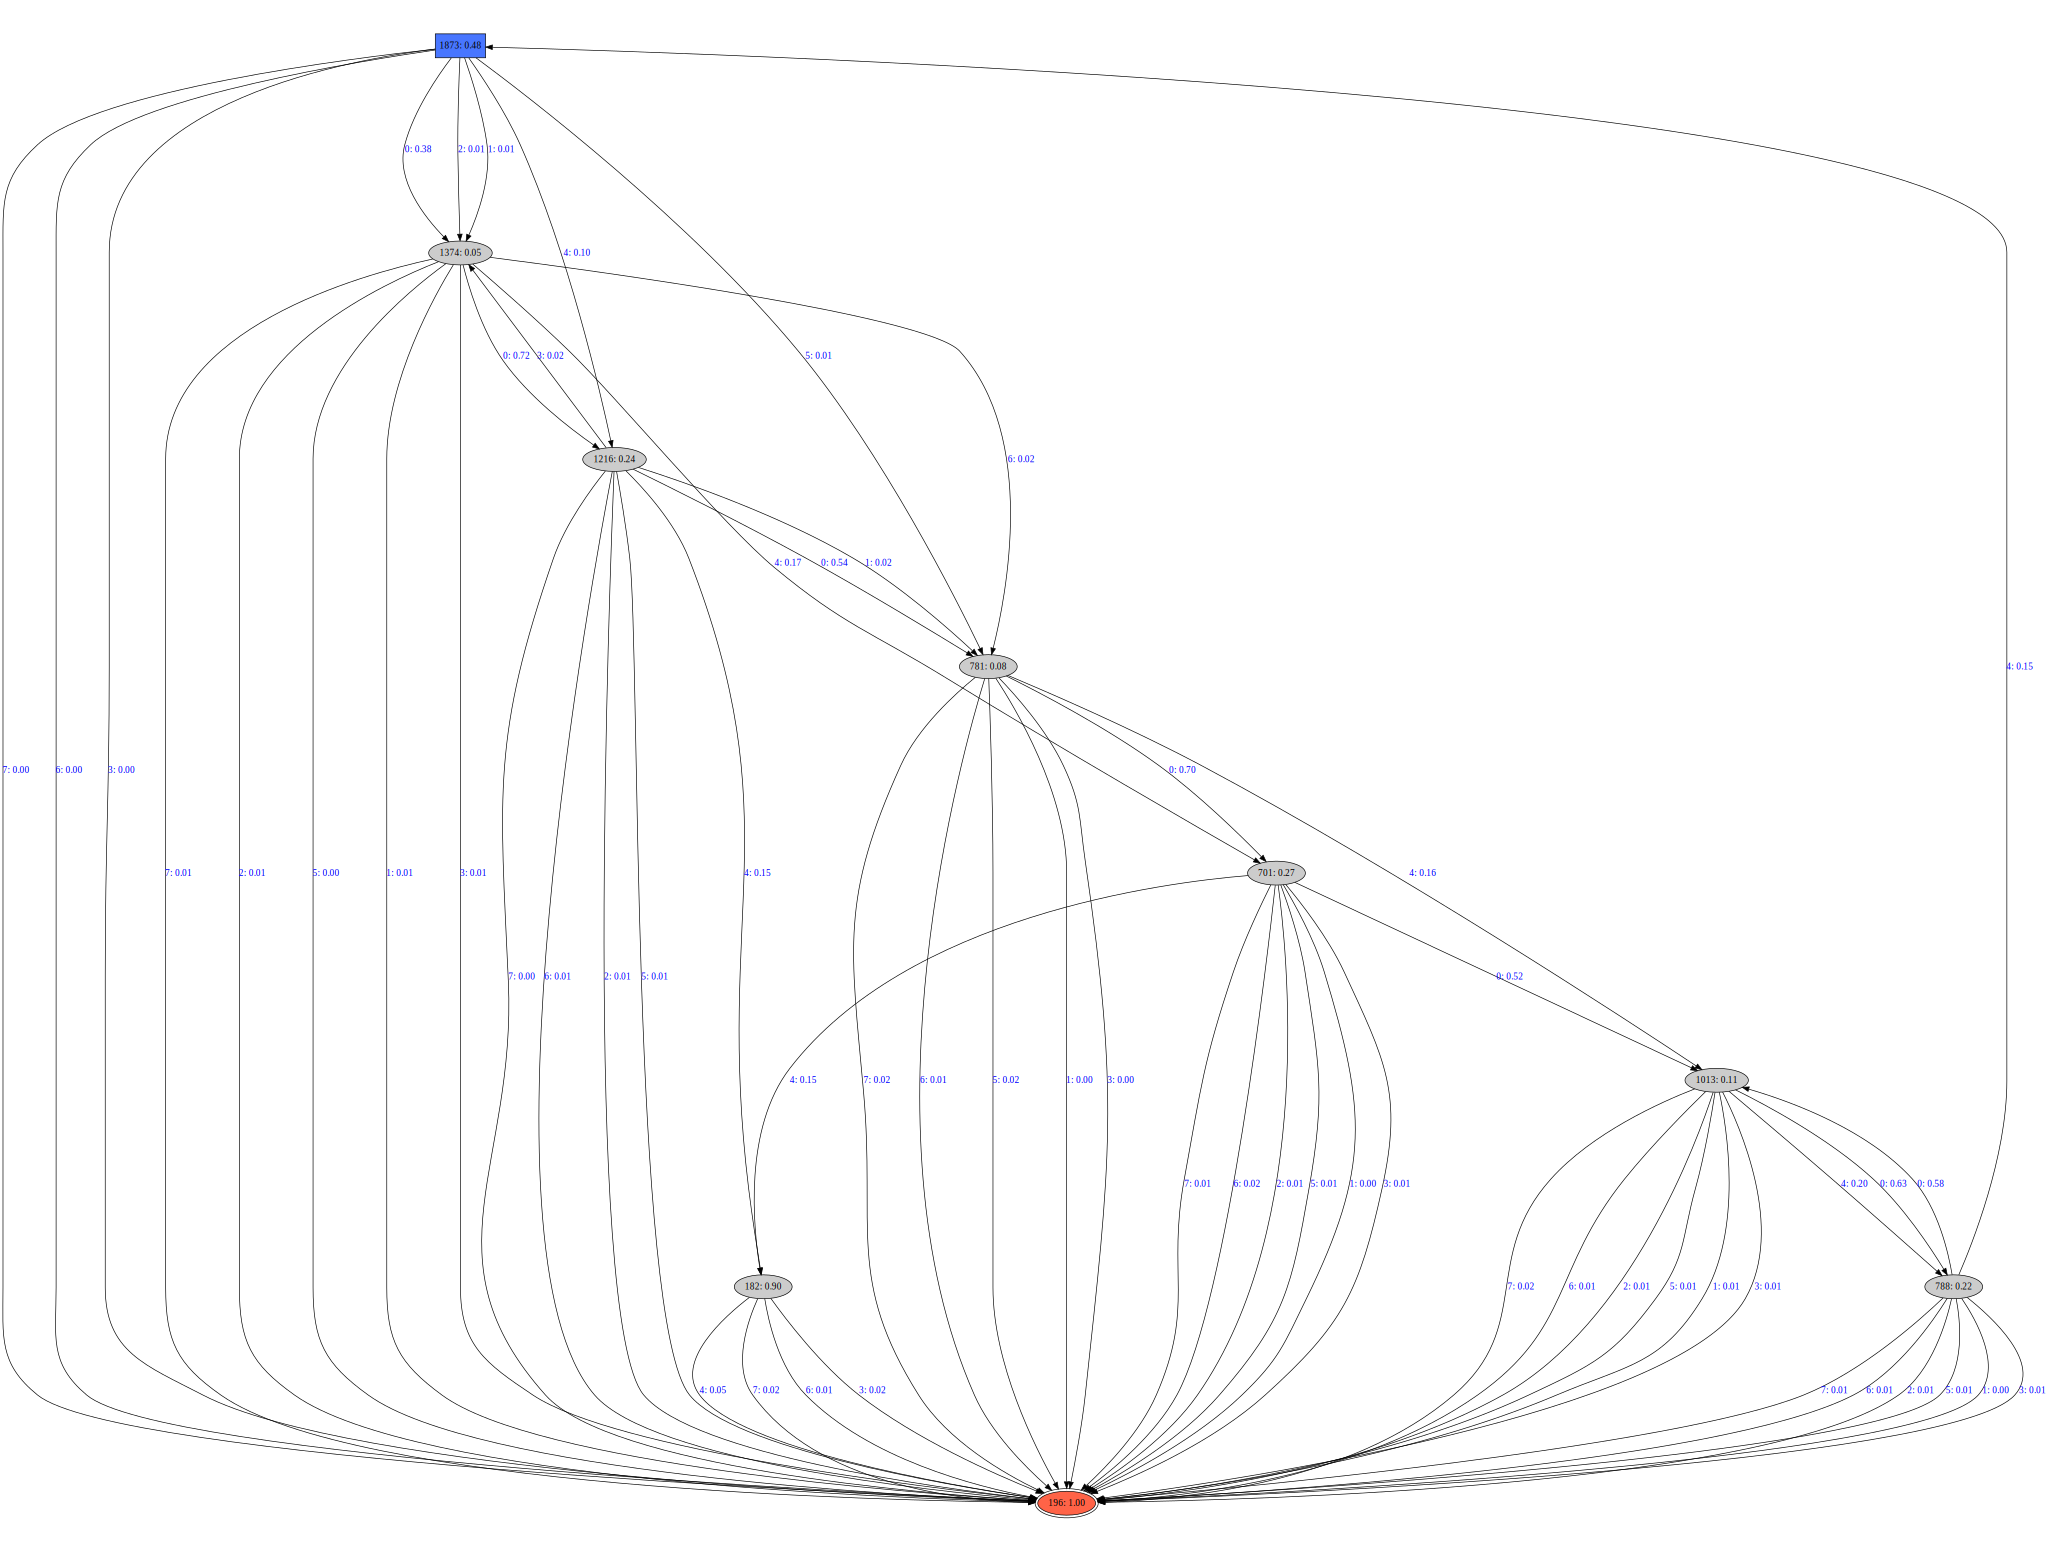

In [67]:
%autoreload 2
from wombats.automaton.pdfa import PDFA

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object')
learned_pdfa.draw_IPython()

## Analyzing Learning Results with Wombats

Here, we want to use the wombats analysis tools to characterize the learning results

### Initial Model Metrics

Here, we will look at some metrics of the learned model. We begin with data-based approximations to information theoretic quantities that we would have available during training time: cross-entropy, perplexity.

 #### Aside: Ergodic, Stationary Processes

PDFA are stationary ergodic stochastic process models (with [a modification](https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1141&context=scil)).

<br>

***ergodic*: time-ensemble average = state-ensemble average**

*[Example +](https://dsp.stackexchange.com/a/58652):*

An eternal well-balanced dice has \(1 / 6\) probability for each facet \(f,\) each time.
This uniform probability law yields a mean expectation of \(3.5: \sum_{f=1}^{6} \frac{1}{6} \times f .\)
Each time you cast the dice, you get this expectation. Of course, for each throw
you" Ill only get an integer \(1,2,3,4,5,\) or \(6,\) never a decimal like \(3.5 .\) So there is
an apparent mismatch between what you can expect (in probability) and what
you get (actually). A mismatch that relates the (theoretical) probability space
and the (real) time space.
The hypothesis of ergodicity may reconcile the two aspects: it tells you that,
averaging over a sufficient number of trials in time, you can get the same
results as if you were capable of throwing an infinity of dice at the same time.
But remember that it is an hypothesis on processes, and that non-ergodic
phenomena exist.

*[Example -](https://en.wikipedia.org/wiki/Fermi%E2%80%93Pasta%E2%80%93Ulam%E2%80%93Tsingou_problem):*

Fermi–Pasta–Ulam–Tsingou problem: letting a vibrating string go with different initial modes as ICs. Intuition was that as this is very non-linear system would over time exhibit all modes equally. Instead, they got out quasi-periodic behavior.

<img src="pres_figures/Fermi–Pasta–Ulam–Tsingou_recurrence_preview.gif">

<br>

***stationary*: process statistics do not change over time**

*Example +:*
Infinitely flipping a fair coin.

*Example -:*
Infinitely flipping a coin that loses mass from one side every flip.



#### Approximate Cross-Entropy

Here, we are using the Shannon-McMillian-Breiman theorem to define
the cross-entropy of the trace, given that we sampled the trace from
the actual target distribution and we are evaluating it in the PDFA LM (SLP ch3). The definition of cross-entropy of the learned language model (LM) distribution $m$ on target LM distribution $p$ is exactly (eq. 3.48 from SLP ch3)
\(H(p, m)=\lim _{n \rightarrow \infty}-\frac{1}{n} \sum_{W \in L} p\left(w_{1}, \ldots, w_{n}\right) \log m\left(w_{1}, \ldots, w_{n}\right)\)

where a trace is a sequence $W \in L$ s.t. $W = w_{1}, \ldots, w_{n}$. The cross-entropy $H(p,m)$ is an upper bound on the entropy $H(p)$:

$H(p) \leq H(p, m)$

<br>

Then, as a PDFA is a stationary ergodic stochastic process model (with [a modification](https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1141&context=scil)), we can calculate the cross-entropy as (eq. 3.49 from SLP ch3):

\(H(p, m)=\lim _{n \rightarrow \infty}-\frac{1}{n} \log m\left(w_{1} w_{2} \ldots w_{n}\right)\)

<br>

The finite-length approximation to the cross-entropy is then given by (eq. 3.51 from SLP ch3):

\(H(W)=-\frac{1}{N} \log P\left(w_{1} w_{2} \dots w_{N}\right)\)

<br>

*reference: [Speech and Language Processing, 3 ed., Ch3](https://web.stanford.edu/~jurafsky/slp3/3.pdf)*

In [68]:
test_cross_ent, train_cross_ent, target_cross_ent = [], [], []
for trace in traces_test:
    test_cross_ent.append(learned_pdfa.cross_entropy_approx(trace))
    target_cross_ent.append(pdfa_model.cross_entropy_approx(trace))
    
for trace in traces_train:
    train_cross_ent.append(learned_pdfa.cross_entropy_approx(trace))

# averaging over all examples
test_cross_ent = np.mean(test_cross_ent)
train_cross_ent = np.mean(train_cross_ent)
target_cross_ent = np.mean(target_cross_ent)
    
print(f"Mean Test Approximate Cross-Entropy of Learned Model: {test_cross_ent}")
print(f"Mean Training Approximate Cross-Entropy of Learned Model: {train_cross_ent}")
print(f"Mean Approximate Cross-Entropy of Target Model: {target_cross_ent}")

Mean Test Approximate Cross-Entropy of Learned Model: 2.335223003406992
Mean Training Approximate Cross-Entropy of Learned Model: 2.3899689126611374
Mean Approximate Cross-Entropy of Target Model: 1.8291915950832318


#### Approximate Perplexity

We can get approximate perplexity directly from approximate cross-entropy (eq. 3.52 SLP):

\(\begin{aligned} \operatorname{Perplexity}(W) &=2^{H(W)} \\ &=P\left(w_{1} w_{2} \ldots w_{N}\right)^{-\frac{1}{N}} \\ &=\sqrt[N]{\frac{1}{P\left(w_{1} w_{2} \ldots w_{N}\right)}} \\ &=\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P\left(w_{i} | w_{1} \ldots w_{i-1}\right)}} \end{aligned}\)

In [69]:
test_perplexity = pow(2, test_cross_ent)
train_perplexity = pow(2, train_cross_ent)
target_perplexity = pow(2, target_cross_ent)
    
print(f"Mean Test Approximate Perplexity of Learned Model: {test_perplexity}")
print(f"Mean Training Approximate Perplexity of Learned Model: {train_perplexity}")
print(f"Mean Approximate Perplexity of Target Model: {target_perplexity}")

Mean Test Approximate Perplexity of Learned Model: 5.046289601133483
Mean Training Approximate Perplexity of Learned Model: 5.241460670691178
Mean Approximate Perplexity of Target Model: 3.553379053537063


#### Actual Cross-Entropy and Perplexity

If we have access to the target distribution $p$, we can compute an exact cross-entropy:
\(H(p, m)= -\frac{1}{N} \sum_{W \in S_{test}} p\left(w_{1}, \ldots, w_{n}\right) \log m\left(w_{1}, \ldots, w_{n}\right)\)

and a perplexity:
\begin{aligned}
\textrm{Perplexity}(p, m) &=2^{H(p, m)}
\end{aligned}
over the test set $S_{test}$ on the learned model $m$.


In [73]:
test_cross_ent = learned_pdfa.cross_entropy(traces_test, trace_probs_test)
train_cross_ent = learned_pdfa.cross_entropy(traces_train, trace_probs_train)
target_cross_ent = pdfa_model.cross_entropy(traces_test, trace_probs_test)
    
print(f"Test Cross-Entropy of Learned Model: {test_cross_ent}")
print(f"Training Cross-Entropy of Learned Model: {train_cross_ent}")
print(f"Cross-Entropy of Target Model: {target_cross_ent}")

Test Cross-Entropy of Learned Model: 0.34228344681895906
Training Cross-Entropy of Learned Model: 0.32784508689827385
Cross-Entropy of Target Model: 0.24152599348313813


perplexity:

In [74]:
test_perplexity = learned_pdfa.perplexity(traces_test, trace_probs_test)
train_perplexity = learned_pdfa.perplexity(traces_train, trace_probs_train)
target_perplexity = pdfa_model.perplexity(traces_test, trace_probs_test)
    
print(f"Test Perplexity of Learned Model: {test_perplexity}")
print(f"Training Perplexity of Learned Model: {train_perplexity}")
print(f"Perplexity of Target Model: {target_perplexity}")

Test Perplexity of Learned Model: 1.2677615751452194
Training Perplexity of Learned Model: 1.255137210450712
Perplexity of Target Model: 1.182242503226289
